# Wisconsin Breast Cancer (Prognostic)

https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Prognostic)

Load the libraries, dataset, basic EDA, feature creation...

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import xgboost as xgb
print('xgb version',xgb.__version__)


xgb version 1.1.0


Using TensorFlow backend.


imblearn version 0.6.1


In [2]:
# load data set
dirpath = r'C:\Users\joeba\OneDrive\Documents\ML\wbcp'

In [3]:
df = pd.read_csv(dirpath+'/wpbc.data.csv')
df.columns

Index(['ID_number', 'Outcome', 'Recurrence_time', 'radius_mean',
       'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
       'compactness_mean', 'concavity_mean', 'concave_points_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'tumor_cm', 'lymph_nodes'],
      dtype='object')

In [4]:
df.shape

(198, 35)

In [5]:
# choose only the recurring instances
df = df[df['Outcome'] == 'R']

In [6]:
df.shape

(47, 35)

In [7]:
# create a rounded time column - to nearest 6 months
df['rTime6'] = df['Recurrence_time'].div(6).round(0) * 6
df.head()

,ID_number,Outcome,Recurrence_time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,tumor_cm,lymph_nodes,rTime6
4,843584,R,27,20.29,14.34,135.10,1297.0,0.1003,0.1328,0.19800,...,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0,0.7572,0.7813,24.0
5,843786,R,77,12.75,15.29,84.60,502.7,0.1189,0.1569,0.16640,...,0.4196,0.5999,0.1709,0.3485,0.11790,2.5,0,0.3877,0.7402,78.0
7,844582,R,77,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,...,0.3682,0.2678,0.1556,0.3196,0.11510,4.0,10,0.5835,1.3770,78.0
13,847990,R,36,14.54,27.54,96.73,658.8,0.1139,0.1595,0.16390,...,0.6577,0.7026,0.1712,0.4218,0.13410,6.0,6,0.3700,1.0330,36.0
15,848620,R,10,16.13,20.68,108.10,798.8,0.1170,0.2022,0.17220,...,0.4233,0.4784,0.2073,0.3706,0.11420,3.0,1,0.5692,1.0730,12.0


In [8]:
# how many in each rounded recurrence time group? - less than 2 will make SMOTE difficult
df['rTime6'].value_counts()

12.0    12
6.0      7
36.0     6
18.0     5
0.0      4
78.0     3
24.0     3
72.0     2
42.0     2
48.0     2
60.0     1
Name: rTime6, dtype: int64

In [9]:
# for simplicity, just keep the mean labelled values
df = df.drop(['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
              'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
              'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'], axis=1)
df.head()

,ID_number,Outcome,Recurrence_time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,tumor_cm,lymph_nodes,rTime6
4,843584,R,27,20.29,14.34,135.10,1297.0,0.1003,0.1328,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,24.0
5,843786,R,77,12.75,15.29,84.60,502.7,0.1189,0.1569,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,78.0
7,844582,R,77,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,78.0
13,847990,R,36,14.54,27.54,96.73,658.8,0.1139,0.1595,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,36.0
15,848620,R,10,16.13,20.68,108.10,798.8,0.1170,0.2022,0.17220,0.10280,0.2164,0.07356,0.5692,1.0730,12.0


In [10]:
# split data into input and output columns
data = df.values
X = data[:, 3:-2]

In [11]:
y = data[:,-1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Simple OLS Regression, in-sample and out-of-sample testing

r2 = 0.3875002475867574


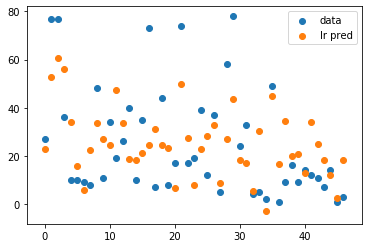

In [13]:
lr = LinearRegression().fit(X,y)
r2 = lr.score(X,y)
print('r2 =',r2)

lr_pred = lr.predict(X)

plt.scatter(range(len(df)), df['Recurrence_time'], label='data')
plt.scatter(range(len(df)), lr_pred, label = 'lr pred')
plt.legend(loc='best')

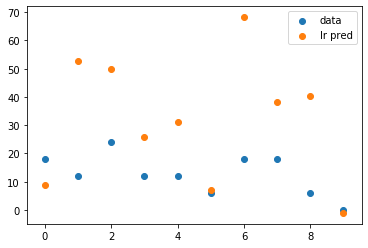

In [14]:
lr.fit(X_train, y_train)
lr_pred=lr.predict(X_test)

plt.scatter(range(len(X_test)), y_test, label='data')
plt.scatter(range(len(X_test)), lr_pred, label = 'lr pred')
plt.legend(loc='best')

XGBoost Regression in-sample and out-of-sample testing

Mean MAE: 17.179 (6.519)


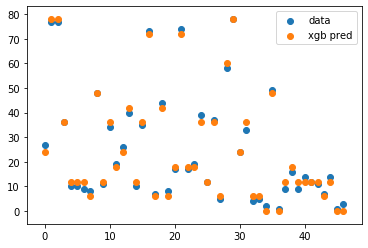

In [15]:
# create an xgboost regression model
model = xgb.XGBRegressor(n_estimators=1000, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# display scores - force scores to be positive to get mean error
#print('Scores: ', scores)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X,y)
xgb_pred = model.predict(X)

plt.scatter(range(len(df)), df['Recurrence_time'], label='data')
plt.scatter(range(len(df)), xgb_pred, label='xgb pred')
plt.legend(loc='best')

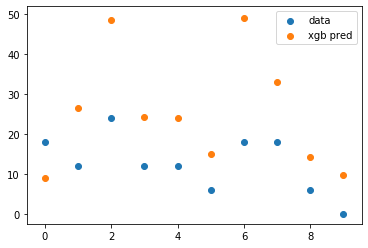

In [16]:
# retrain the model on 80% of the data - test on 20%
model.fit(X_train, y_train)
xgb_pred = model.predict(X_test)

plt.scatter(range(len(X_test)), y_test, label='data')
plt.scatter(range(len(X_test)), xgb_pred, label = 'xgb pred')
plt.legend(loc='best')


Refactor the recurrence times based on clustering the tumour data

In [17]:
# reset the dataset
X = df[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 
        'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'tumor_cm', 
        'lymph_nodes']]
y = df[['rTime6']]

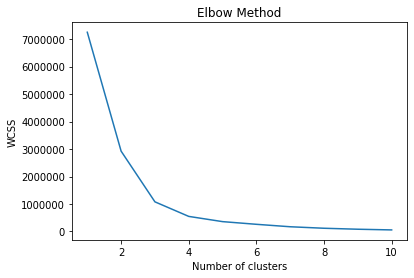

In [18]:
# k-means on the data
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [19]:
# re-run with k=4
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_

array([3, 2, 2, 2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 1, 3, 1, 1, 3, 1, 3, 0, 2,
       2, 3, 3, 1, 1, 3, 3, 2, 0, 3, 0, 2, 3, 2, 3, 2, 1, 3, 3, 1, 3, 0,
       1, 1, 3])

In [21]:
df['cluster'] = kmeans.labels_
df.head()

,ID_number,Outcome,Recurrence_time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,tumor_cm,lymph_nodes,rTime6,cluster
4,843584,R,27,20.29,14.34,135.10,1297.0,0.1003,0.1328,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,24.0,3
5,843786,R,77,12.75,15.29,84.60,502.7,0.1189,0.1569,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,78.0,2
7,844582,R,77,13.71,20.83,90.20,577.9,0.1189,0.1645,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,78.0,2
13,847990,R,36,14.54,27.54,96.73,658.8,0.1139,0.1595,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,36.0,2
15,848620,R,10,16.13,20.68,108.10,798.8,0.1170,0.2022,0.17220,0.10280,0.2164,0.07356,0.5692,1.0730,12.0,2


In [22]:
r0 = df[df['cluster'] == 0]
r0m = np.round(np.mean(r0['Recurrence_time']),0)
r1 = df[df['cluster'] == 1]
r1m = np.round(np.mean(r1['Recurrence_time']),0)
r2 = df[df['cluster'] == 2]
r2m = np.round(np.mean(r2['Recurrence_time']),0)
r3 = df[df['cluster'] == 3]
r3m = np.round(np.mean(r3['Recurrence_time']),0)

In [23]:
print('cluster 0 - mean recurrence time =', r0m)
print('cluster 1 - mean recurrence time =', r1m)
print('cluster 2 - mean recurrence time =', r2m)
print('cluster 3 - mean recurrence time =', r3m)

cluster 0 - mean recurrence time = 13.0
cluster 1 - mean recurrence time = 24.0
cluster 2 - mean recurrence time = 40.0
cluster 3 - mean recurrence time = 16.0


In [24]:
df['rTimeC'] = r0m
for i in range(len(df)):
    if df.iloc[i,-2] == 1:
        df.iat[i,-1] = r1m
    elif df.iloc[i,-2] == 2:
        df.iat[i,-1] = r2m
    elif df.iloc[i,-2] == 3:
        df.iat[i,-1] = r3m
        
df.head(10)

,ID_number,Outcome,Recurrence_time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,tumor_cm,lymph_nodes,rTime6,cluster,rTimeC
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,24.0,3,16.0
5,843786,R,77,12.75,15.29,84.60,502.7,0.11890,0.15690,0.16640,0.07666,0.1995,0.07164,0.3877,0.7402,78.0,2,40.0
7,844582,R,77,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,78.0,2,40.0
13,847990,R,36,14.54,27.54,96.73,658.8,0.11390,0.15950,0.16390,0.07364,0.2303,0.07077,0.3700,1.0330,36.0,2,40.0
15,848620,R,10,16.13,20.68,108.10,798.8,0.11700,0.20220,0.17220,0.10280,0.2164,0.07356,0.5692,1.0730,12.0,2,40.0
17,851509,R,10,21.16,23.04,137.20,1404.0,0.09428,0.10220,0.10970,0.08632,0.1769,0.05278,0.6917,1.1270,12.0,3,16.0
34,855625,R,9,19.07,24.81,128.30,1104.0,0.09081,0.21900,0.21070,0.09961,0.2310,0.06343,0.9811,1.6660,12.0,1,24.0
37,857010,R,8,18.65,17.60,123.70,1076.0,0.10990,0.16860,0.19740,0.10090,0.1907,0.06049,0.6289,0.6633,6.0,1,24.0
39,857438,R,48,15.10,22.02,97.26,712.8,0.09056,0.07081,0.05253,0.03334,0.1616,0.05684,0.3105,0.8339,48.0,2,40.0
40,857637,R,11,19.21,18.57,125.50,1152.0,0.10530,0.12670,0.13230,0.08994,0.1917,0.05961,0.7275,1.1930,12.0,1,24.0


In [25]:
# split data into input and output columns
data = df.values
X = data[:, 3:14]

In [26]:
X[0:4]

array([[20.29, 14.34, 135.1, 1297.0, 0.1003, 0.1328, 0.198, 0.1043,
        0.1809, 0.05882999999999999, 0.7572],
       [12.75, 15.29, 84.6, 502.7, 0.1189, 0.1569, 0.1664, 0.07666,
        0.1995, 0.07164, 0.3877],
       [13.71, 20.83, 90.2, 577.9, 0.1189, 0.1645, 0.09366000000000001,
        0.05985, 0.2196, 0.07451, 0.5835],
       [14.54, 27.54, 96.73, 658.8, 0.1139, 0.1595, 0.1639, 0.07364,
        0.2303, 0.07077, 0.37]], dtype=object)

In [27]:
y = data[:,-1]

In [28]:
y

array([16.0, 40.0, 40.0, 40.0, 40.0, 16.0, 24.0, 24.0, 40.0, 24.0, 40.0,
       40.0, 40.0, 24.0, 16.0, 24.0, 24.0, 16.0, 24.0, 16.0, 13.0, 40.0,
       40.0, 16.0, 16.0, 24.0, 24.0, 16.0, 16.0, 40.0, 13.0, 16.0, 13.0,
       40.0, 16.0, 40.0, 16.0, 40.0, 24.0, 16.0, 16.0, 24.0, 16.0, 13.0,
       24.0, 24.0, 16.0], dtype=object)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

OLS Regression on resampled data, in-sample and out-of-sample testing

r2= 0.8842524937539827


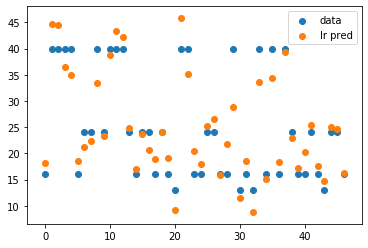

In [30]:
lr = LinearRegression().fit(X,y)
r2 = lr.score(X,y)
print('r2=',r2)

lr_pred = lr.predict(X)

plt.scatter(range(len(df)), df['rTimeC'], label='data')
plt.scatter(range(len(df)), lr_pred, label = 'lr pred')
plt.legend(loc='best')

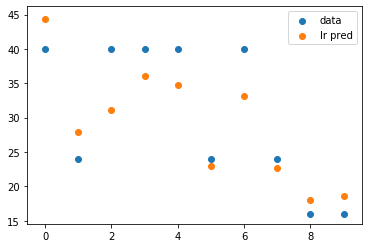

In [31]:
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)
plt.scatter(range(len(X_test)), y_test, label='data')
plt.scatter(range(len(X_test)), lr_pred, label = 'lr pred')
plt.legend(loc='best')

XGBoost Regression on resampled data, in-sample and out-of-sample testing

Mean MAE: 0.281 (0.386)


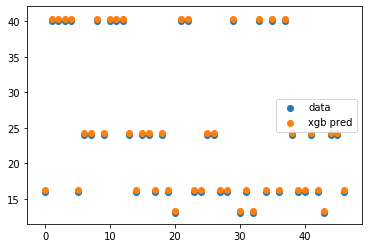

In [33]:
# create an xgboost regression model
model = xgb.XGBRegressor(n_estimators=1000, max_depth=12, eta=0.1, subsample=0.7, colsample_bytree=0.8)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# display scores - force scores to be positive to get mean error
#print('Scores: ', scores)
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X,y)
xgb_pred = model.predict(X)
for i in range(len(xgb_pred)):
    xgb_pred[i] = xgb_pred[i]+scores.mean()

plt.scatter(range(len(df)), df['rTimeC'], label='data')
plt.scatter(range(len(df)), xgb_pred, label='xgb pred')
plt.legend(loc='best')

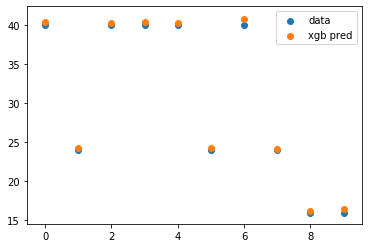

In [34]:
model.fit(X_train, y_train)
xgb_pred = model.predict(X_test)

for i in range(len(xgb_pred)):
    xgb_pred[i] = xgb_pred[i]+scores.mean()
    
plt.scatter(range(len(X_test)), y_test, label='data')
plt.scatter(range(len(X_test)), xgb_pred, label = 'xgb pred')
plt.legend(loc='best')
